<a href="https://colab.research.google.com/github/VincentCsNv/SPARKS/blob/main/Classification_CIFAR/classif_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
!pip install torch torchvision --quiet
!pip install sympy==1.13.1 --quiet


In [114]:
#Visualization of preds
#review training
#Check weight decay
#test

In [115]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision.datasets import CIFAR100
import torchvision.transforms as tt
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns



In [116]:
super_classes_dict = {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
'household electrical device': ['clock', 'computer_keyboard', 'lamp', 'telephone', 'television'],
'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
'people': ['baby', 'boy', 'girl', 'man', 'woman'],
'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

In [117]:
#PARAMETERS
SUPER_CLASSES = ["aquatic mammals","household furniture","trees"]


# 1. Prepare the dataset (CIFAR 100) :

In [118]:
#Useful functions :
#Sort Dataset
def getting_classes_selected(superclass_selected,superclass_dict):
  '''
  Function to get the classes associated to an ensemble of superclasses
  '''
  classes_selected = []
  for superclass in super_class_selected:
    classes_selected = classes_selected + super_classes_dict[superclass]
  return classes_selected

def get_idx_classes(class_selected,data):
  return data.class_to_idx[class_selected]


def getting_subset_df(data,super_classes_dict,SUPER_CLASSES):

  data_df = pd.DataFrame()
  data_df["id_img"] = np.arange(len(data))
  data_df["label"] = data.targets
  data_df["class"] = data_df["label"].apply(lambda x : data.classes[x])

  superc_class_df =  pd.DataFrame([
      {'class': class_name, 'superclass': super_class}
      for super_class, classes in super_classes_dict.items()
      for class_name in classes
  ])
  data_df = data_df.merge(superc_class_df, on='class', how="left")
  #Sort by superclasses
  data_df = data_df[data_df["superclass"].isin(SUPER_CLASSES)]
  #Adding labels according to superclass
  #data_df["label_A"] = data_df["superclass"].apply(lambda superclass : SUPER_CLASSES.index(superclass) )
  #data_df["label_B"] = np.arange(len(data_df))
  return data_df

def get_eq_df(train_df,SUPER_CLASSES):
  '''
  To adapt computing to the several options. (classification per classes or superclasses)
  '''
  eq_df = pd.DataFrame(columns=['class','superclass'])
  eq_df['label'] = train_df["label"].unique()
  eq_df['class'] = eq_df["label"].apply(lambda x : train_df[train_df["label"]== x]["class"].values[0] )
  eq_df['superclass'] = eq_df["class"].apply(lambda x : train_df[train_df["class"]== x]["superclass"].values[0] )
  eq_df = eq_df.sort_values(by="superclass")
  eq_df["label_A"] = eq_df["superclass"].apply(lambda superclass : SUPER_CLASSES.index(superclass) )
  eq_df["label_B"] = np.arange(len(eq_df))
  return eq_df

#Test/ Visualization
def transform_visualisation(data):
  plt.figure(figsize=(5, 3))
  for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = data[0][0].permute(1, 2, 0) #permute columns to have the great order.
    img=img*0.5 +0.5 #We denormalize the img
    plt.imshow(img)

def histogram_data_df(class_cat,train_df,test_df):
  #Count repartition of images
  rep_class_train = train_df[class_cat].value_counts()
  rep_class_test = test_df[class_cat].value_counts()
  #plot histogram
  rep_class_train.plot(kind='bar',color="skyblue",label="training set")
  rep_class_test.plot(kind='bar',color="orange", label = "test set")
  plt.title(f"Histogram of classes in {class_cat}")
  plt.legend()
  plt.xlabel('Classes')
  plt.ylabel('Number of images')
  plt.show()


def show_img(sub_data,data,random = True):

  plt.figure(figsize=(6, 3))

  if random:
    img_idx = np.random.randint(0, len(sub_data),25)
  else:
    img_idx = np.arange(25)


  for i in range(8):
      idx = img_idx[i]
      plt.subplot(2, 4, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      img = sub_data[idx][0].permute(1, 2, 0) #permute columns to have the great order.
      img=img*0.5 +0.5 #We denormalize the img
      plt.imshow(img)
      plt.title(data.classes[sub_data[idx][1]])


In [119]:
#data augmentation
#Random transformation for the training (data Augmentation)
train_transform = tt.Compose(
    [tt.RandomHorizontalFlip(),
     tt.RandomVerticalFlip(),
     tt.RandomRotation(10),
     #ADD Transformation
     tt.ToTensor(),
     tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # EXPLAIN DEVDEVDEV

#For the test we want to avoid random layer, to keep relevant results
test_transform = tt.Compose(
    [tt.ToTensor(),
     tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [120]:
# Load CIFAR dataset
train_data = CIFAR100(root="data",download = True, transform = train_transform) #Adding Data Augmentation with transform
test_data = CIFAR100(root="data",train = False,download = True, transform = test_transform) #Adding Data Augmentation with transform

#Getting subset df
train_df = getting_subset_df(train_data,super_classes_dict,SUPER_CLASSES)
test_df = getting_subset_df(test_data,super_classes_dict,SUPER_CLASSES)
eq_df = get_eq_df(train_df,SUPER_CLASSES)

#Getting subset
trainset = torch.utils.data.Subset(train_data, train_df["id_img"].values)
testset = torch.utils.data.Subset(test_data, test_df["id_img"].values)

print(f"nb of training images {len(trainset)}, nb of test images {len(testset)}")

nb of training images 7500, nb of test images 1500


Visualization of a sample of the dataset :


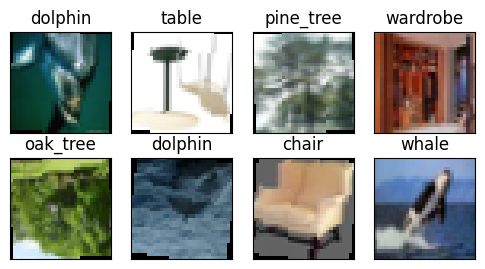

In [121]:
#Observe the dataset
print("Visualization of a sample of the dataset :")
show_img(trainset,train_data, random = True)

Visualization of random transformation on an image


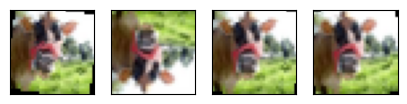

In [122]:
#Observe random transformation :
print("Visualization of random transformation on an image")
transform_visualisation(train_data)

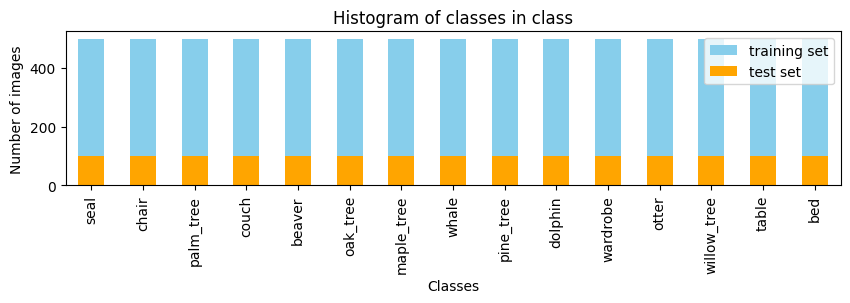

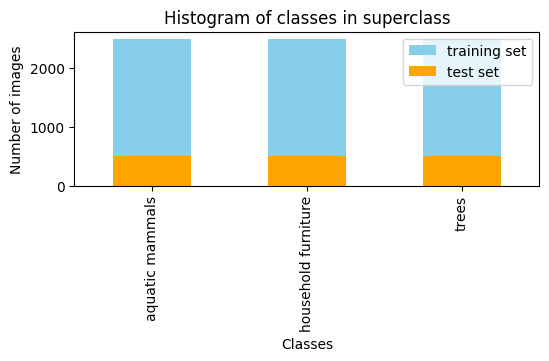

In [123]:
#Histogram repartion per class
plt.figure(figsize=(10, 2))
histogram_data_df("class",train_df,test_df)
#Histogram repartition per superclass
plt.figure(figsize=(6, 2))
histogram_data_df("superclass",train_df,test_df)

# 2. Training models :

## A. Classification in super-classes :

### a. Define models :

In [85]:
'''
#model pre-trained
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
'''

"\n#model pre-trained\nimport torch\nmodel = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)\n"

In [124]:
#Model create layer by layer
class convnet_no_dropout(nn.Module):
    # Constructor
    def __init__(self,nb_class):
        super(convnet_no_dropout, self).__init__()
        '''
         Convolutional layers
         Conv2d (input channels, output channels, kernel_size, padding)

        Each Sequential layer has :
              1. A Convolutional Layer
              2. Relu activation function
              3. Maxpool layer
        '''
        self.nb_class = nb_class

        self.conv_layer_1 = torch.nn.Sequential(
            # Convoolutional layer
            nn.Conv2d(in_channels=3, out_channels=16,kernel_size= 3,stride=1, padding=1),

            # Activation function
            nn.ReLU(),

            # Max pooling layer
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.conv_layer_2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )


        self.conv_layer_3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer_4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )


        # Fully Connected layers
        self.hidden_layer = nn.Linear(128*2*2, 206)
        self.output_layer = nn.Linear(206, self.nb_class)

    def forward(self, ip):

        # Calling all the convolutional layers
        output = self.conv_layer_1(ip)
        output = self.conv_layer_2(output)
        output = self.conv_layer_3(output)
        output = self.conv_layer_4(output)

        # Flattening
        output = output.view(-1, 128*2*2)

        # Call fully connected layer
        output = self.hidden_layer(output)

        output=self.output_layer(output)

        return output


## B. Training:




In [160]:
def convert_labels(labels,eq_df,new_label,old_label):
  labels_list = labels.tolist()
  #new_labels = [label for label in labels_list]

  new_labels = [eq_df[eq_df[old_label]== label][new_label].values[0] for label in labels_list]
  new_labels_tensor = torch.tensor(new_labels)
  return new_labels_tensor


#test the accuracy function
preds = [[0.3,-0.1,-0.1,0.,0.,0.,0.,0.5,0.,0.,0.,0.,0.,0.,0.],[0.3,-0.1,-0.1,0,0,0,0,0,0,0,0,0,0,0.9,0],[0.3,-0.1,-0.1,0,0,0,0,0,0,0,0,0,0,0,0]]
labels = [7,7,10]
preds = torch.tensor(preds)
labels = torch.tensor(labels)

accuracy_B(preds,labels)


tensor(0.3333)

In [212]:
def convert_labels(labels,eq_df,old_label,new_label):
  labels_list = labels.tolist()
  #new_labels = [label for label in labels_list]

  new_labels = [eq_df[eq_df[old_label]== label_nb][new_label].values[0] for label_nb in labels_list]
  new_labels_tensor = torch.tensor(new_labels)
  return new_labels_tensor

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

def accuracy_B(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    #convert label to superclasses
    preds_B = convert_labels(preds,eq_df,old_label = "label_B",new_label = "label_A")
    labels_B = convert_labels(labels,eq_df,old_label = "label_B",new_label = "label_A")
    return torch.tensor(torch.sum(preds_B == labels_B).item()/len(preds))

def evaluate(model,valid_dl,loss_func,mode = "A"):
    model.eval()
    batch_losses, batch_accs=[],[]
    for images,labels in valid_dl:
        labels = convert_labels(labels,eq_df,old_label = "label",new_label = f"label_{mode}")
        predicted=model(images)
        batch_losses.append(loss_func(predicted,labels))
        if mode == "A":
          batch_accs.append(accuracy(predicted,labels))
        elif mode == "B":
          batch_accs.append(accuracy_B(predicted,labels))
    epoch_avg_loss=torch.stack(batch_losses).mean().item()# To keep only the mean
    epoch_avg_acc=torch.stack(batch_accs).mean().item()
    return epoch_avg_loss,epoch_avg_acc

def train(model,train_dl,valid_dl,epochs, max_lr, loss_func,optim,eq_df,mode="A"):

    '''
    Optimizer
    '''
    if optim == "Adam":
      optimizer = torch.optim.Adam(model.parameters(), max_lr,weight_decay=1e-5)
    elif optim == "SGD":
      optimizer= torch.optim.SGD(model.parameters(), max_lr,weight_decay=1e-5)
    elif optim == "Momentum":
      optimizer=torch.optim.SGD(model.parameters(), max_lr,momentum=0.9,weight_decay=1e-5)


    '''
    Learning Rate Scheduler
    '''
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs*len(train_dl)) #VOIR CE QUE CEST EN SOIT
#     scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=5,verbose=True)
#     scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)

    results=[]
    for epoch in range(epochs):
        model.train()
        train_losses, train_batch_accs, lrs =[],[],[]

        #Compute over a minibatch
        for images, labels in train_dl:
          labels = convert_labels(labels,eq_df,old_label = "label",new_label = f"label_{mode}") # Adapt to the classes (Option A or B)
          optimizer.zero_grad() #Gradient set to zero to avoid accumulation during training (Backprog at the scale of mini-batch)
          predicted=model(images)
          loss=loss_func(predicted,labels)
          train_losses.append(loss)
          loss.backward() #Backpropagation verify what it is
          optimizer.step() # Compute the optimization of the gradient descent.

          # keep track of learning rate
          lrs.append(optimizer.param_groups[0]['lr'])
          if mode == "A":
            train_batch_accs.append(accuracy(predicted,labels))
          elif mode == "B":
            train_batch_accs.append(accuracy_B(predicted,labels)) #For Option B, the classification is made on classes, but the accuracy compute according superclasses.
        scheduler.step() #
        epoch_train_acc=torch.stack(train_batch_accs).mean().item()
        epoch_train_loss=torch.stack(train_losses).mean().item()
        epoch_avg_loss,epoch_avg_acc=evaluate(model,valid_dl,loss_func,mode=mode) #having the avg metrics for the epoch.

        results.append({'avg_valid_loss': epoch_avg_loss,
                        'avg_val_acc': epoch_avg_acc,
                        'avg_train_loss':epoch_train_loss,
                        'avg_train_acc':epoch_train_acc,
                        'lrs':lrs})

        print('Number of epochs:', epoch,'|',
              'Validation loss :',epoch_avg_loss, ' |','Training loss :'
              ,epoch_train_loss,' |  '
              ,'Training accuracy:', epoch_train_acc
              , 'validation accuracy :',epoch_avg_acc)
        #Save the model weight
        torch.save(model.state_dict(), 'model_weights.pth')
    return results






In [209]:
#test the accuracy function
preds = [[0.3,-0.1,-0.1],[0.3,0.1,-0.1],[-0.3,0.1,-0.1]]
labels = [0,1,1]
preds = torch.tensor(preds)
labels = torch.tensor(labels)
accuracy(preds,labels)

tensor(0.6667)

In [213]:
#TRAINING Options
#Parameters
OPTION = "B" #A or B
BATCH_SIZE = 32
MAX_LR = 1e-2 #Best 1e-1 for Momentum
EPOCHS = 5
FROM_CKP = False
optim = "Adam" #Adam, SGD or Momentum

if OPTION == "A":
  nb_class = len(SUPER_CLASSES)
elif OPTION == "B":
  nb_class = len(train_df["class"].unique())

#loading model
model = convnet_no_dropout(nb_class = nb_class)
if FROM_CKP:
  model.load_state_dict(torch.load('model_weights.pth'))



#Loss and Optimize
loss_func=nn.functional.cross_entropy # example : nn.functional.cross_entropy

#Call training functions
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
results= train(model,trainloader,testloader,EPOCHS, MAX_LR, loss_func,optim,eq_df,mode=OPTION)

Number of epochs: 0 | Validation loss : 2.0750114917755127  | Training loss : 2.330779790878296  |   Training accuracy: 0.5846187472343445 validation accuracy : 0.7003229260444641
Number of epochs: 1 | Validation loss : 1.9113905429840088  | Training loss : 2.0039334297180176  |   Training accuracy: 0.7047872543334961 validation accuracy : 0.7239741683006287
Number of epochs: 2 | Validation loss : 1.829875111579895  | Training loss : 1.8477163314819336  |   Training accuracy: 0.7565602660179138 validation accuracy : 0.7696618437767029
Number of epochs: 3 | Validation loss : 1.6967629194259644  | Training loss : 1.7481603622436523  |   Training accuracy: 0.7824910879135132 validation accuracy : 0.7936930656433105
Number of epochs: 4 | Validation loss : 1.6983660459518433  | Training loss : 1.6663793325424194  |   Training accuracy: 0.7988032102584839 validation accuracy : 0.8029065132141113


In [190]:

#Getting Metrics
avg_training_accuracy, avg_validation_accuracy =[], []
avg_training_loss, avg_validation_loss=[],[]
for result in results:
    avg_training_accuracy.append(result['avg_train_acc'])
    avg_validation_accuracy.append(result['avg_val_acc'])
    avg_validation_loss.append(result['avg_valid_loss'])
    avg_training_loss.append(result['avg_train_loss'])

epoch_count=[]
for i in range(EPOCHS):
    epoch_count.append(i)

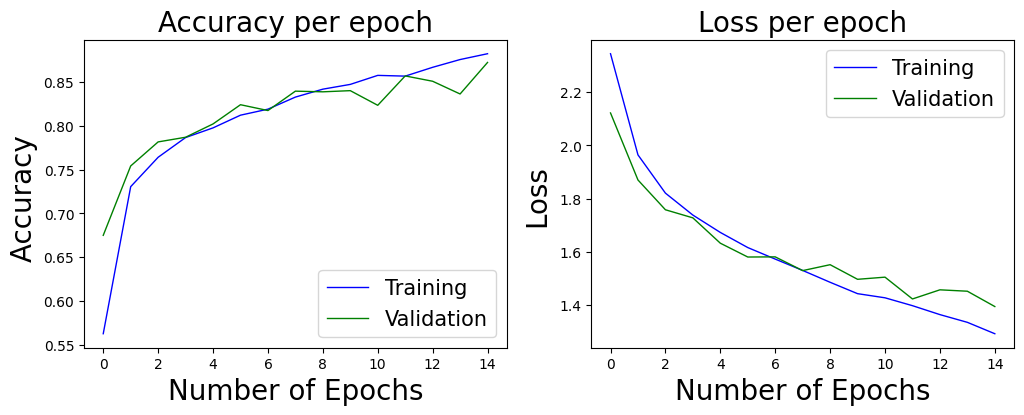

In [197]:
#ADD LOSS
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epoch_count,avg_training_accuracy, 'blue', label = "Training", linewidth = '1')
plt.plot(epoch_count,avg_validation_accuracy, 'green', label = "Validation", linewidth = '1')
plt.title("Accuracy per epoch",fontsize=20)
plt.xlabel("Number of Epochs",fontsize=20)
plt.ylabel("Accuracy ",fontsize=20)
plt.legend(fontsize=15)

plt.subplot(1,2,2)
plt.plot(epoch_count,avg_training_loss, 'blue', label = "Training", linewidth = '1')
plt.plot(epoch_count,avg_validation_loss, 'green', label = "Validation", linewidth = '1')
plt.title("Loss per epoch",fontsize=20)
plt.xlabel("Number of Epochs",fontsize=20)
plt.ylabel("Loss ",fontsize=20)
plt.legend(fontsize=15)
plt.show()

#. Evaluate models:

In [192]:
#On charge les poids du modèle.
model_eval = convnet_no_dropout(nb_class=nb_class)
model_eval.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [193]:
#Eval the model on the test dataset (Metrics + Confusion Matrix)
model_eval.eval()
batch_losses, batch_accs=[],[]
all_predictions, all_labels = [], []  # Pour la matrice de confusion
i=0

for images,labels in testloader:
  labels = convert_labels(labels,eq_df,old_label="label",new_label="label_B")
  predicted=model_eval(images)
  batch_losses.append(loss_func(predicted,labels))
  if OPTION == "A":
    batch_accs.append(accuracy(predicted,labels))
  elif OPTION == "B":
    acc = accuracy_B(predicted,labels)
    batch_accs.append(accuracy_B(predicted,labels))

  # Collecter pour matrice de confusion
  _, pred_classes = torch.max(predicted, 1)  # Classes prédites
  preds = convert_labels(pred_classes,eq_df,old_label="label_B",new_label="label_A")
  labels_A = convert_labels(labels,eq_df,old_label="label_B",new_label="label_A")
  all_predictions.extend(preds.cpu().numpy())
  all_labels.extend(labels_A.cpu().numpy())

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       500
           1       0.89      0.84      0.86       500
           2       0.93      0.86      0.89       500

    accuracy                           0.87      1500
   macro avg       0.88      0.87      0.87      1500
weighted avg       0.88      0.87      0.87      1500



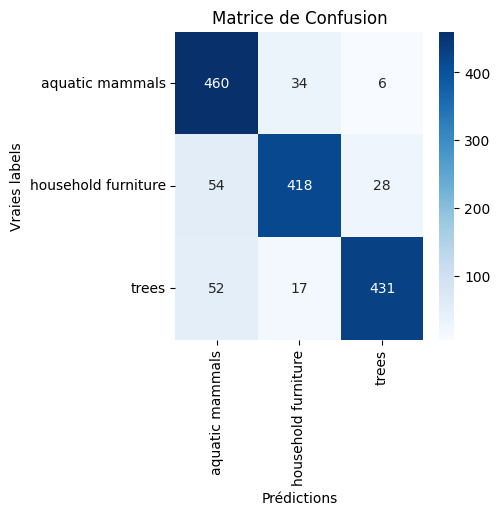

In [194]:
from sklearn.metrics import confusion_matrix, classification_report
# Créer la matrice de confusion
cm = confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

# Plot de la matrice de confusion
class_names = SUPER_CLASSES
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.ylabel('Vraies labels')
plt.xlabel('Prédictions')
plt.show()

In [195]:
def predict_img(img,model):
  yb = model(img)
  _, pred = torch.max(yb, dim=1)
  pred = pred.item()
  return pred

i = np.random.randint(0, len(trainset))
img,label = trainset[i]
pred = predict_img(img,model_eval)
print(label)
truth = eq_df[eq_df["label"]==label]["superclass"].values
pred_name = eq_df[eq_df["label_A"]==pred]["superclass"].values[0]
print(f"ground thruth: {truth}, pred :{pred_name} ")
plt.imshow(img.permute(1, 2, 0))


52


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
#FUNCTIONS TO SHOW SOME PREDS.

array([], dtype=object)